In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load historical portfolio value
portfolio = pd.read_csv("../outputs/results/high_growth_portfolio_value.csv", index_col=0, parse_dates=True).squeeze()
portfolio = portfolio.dropna()


c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model

📐 Best geometric model: trend='add', damped=False, MSE=0.02


c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


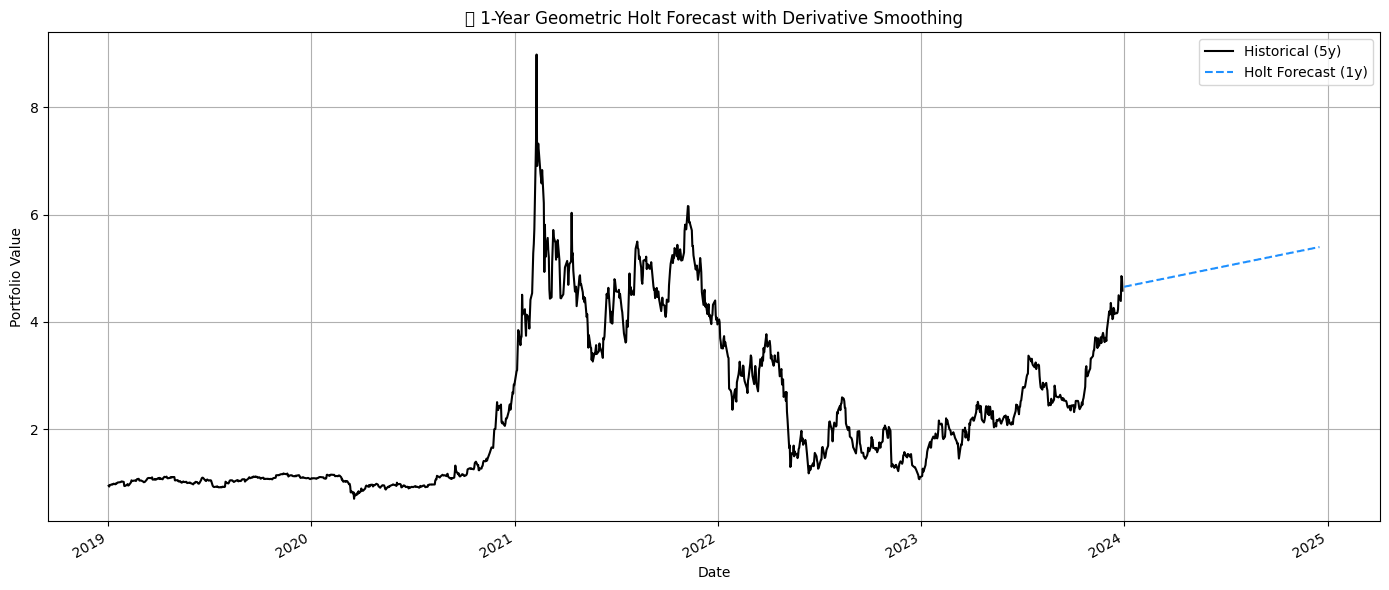

c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


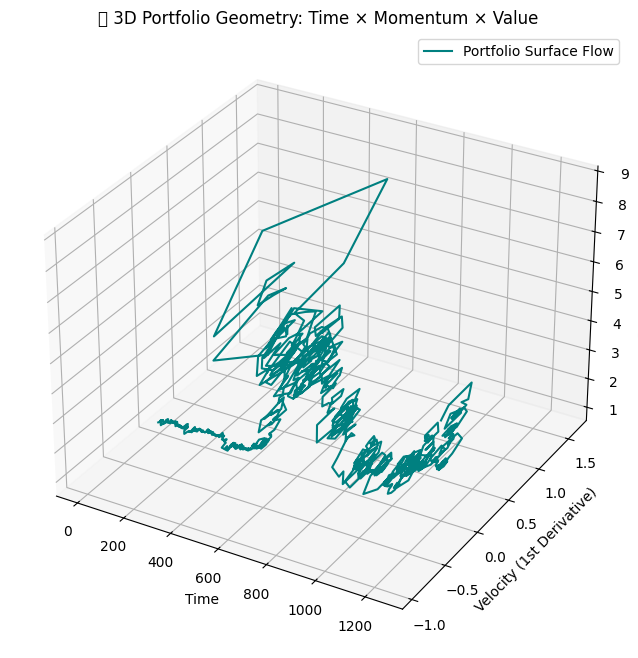

In [ ]:
# 📐 Geometrically Optimized Holt Forecast + 3D Derivative Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse
from mpl_toolkits.mplot3d import Axes3D

# === Load Portfolio ===
portfolio = pd.read_csv("../outputs/results/high_growth_portfolio_value.csv", index_col=0, parse_dates=True).squeeze()
portfolio = portfolio.dropna()

# === Derivative-Based Smoothing ===
def first_derivative(series): return np.gradient(series.values)
def second_derivative(series): return np.gradient(first_derivative(series))

def smooth_series_geometry(series, w1=0.3, w2=0.2):
    grad1 = pd.Series(first_derivative(series), index=series.index).rolling(window=3, min_periods=1).mean()
    grad2 = pd.Series(second_derivative(series), index=series.index).rolling(window=3, min_periods=1).mean()
    return series - w1 * grad1 - w2 * grad2

# === Forecast Function with Trend Optimization ===
def forecast_portfolio_holt_geometric(series, steps=30):
    smoothed = smooth_series_geometry(series)
    best_model, best_score, best_params = None, float('inf'), {}

    for trend in ['add', 'mul']:
        for damped in [True, False]:
            try:
                model = ExponentialSmoothing(smoothed, trend=trend, damped_trend=damped, seasonal=None)
                fit = model.fit(optimized=True)
                score = mse(smoothed[-30:], fit.fittedvalues[-30:])
                if score < best_score:
                    best_model = fit
                    best_score = score
                    best_params = {'trend': trend, 'damped': damped}
            except: continue

    print(f"📐 Best geometric model: trend='{best_params['trend']}', damped={best_params['damped']}, MSE={best_score:.2f}")
    future_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    forecast = best_model.forecast(steps)
    forecast.index = future_index
    return forecast

# === Forecast 1 Year into Future (252 Business Days)
holt_forecast = forecast_portfolio_holt_geometric(portfolio, steps=504)

# === Plot Long-Term Forecast vs Historical
plt.figure(figsize=(14, 6))
portfolio.plot(label="Historical (5y)", color="black")
holt_forecast.plot(label="Holt Forecast (1y)", linestyle="--", color="dodgerblue")
plt.title("📈 1-Year Geometric Holt Forecast with Derivative Smoothing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === 3D Visualization of Portfolio Geometry ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x = np.arange(len(portfolio))
y = np.gradient(portfolio.values)
z = portfolio.values
ax.plot(x, y, z, label='Portfolio Surface Flow', color='teal')
ax.set_xlabel("Time")
ax.set_ylabel("Velocity (1st Derivative)")
ax.set_zlabel("Portfolio Value")
ax.set_title("🧠 3D Portfolio Geometry: Time × Momentum × Value")
ax.legend()
plt.show()
